In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Union, Any
%matplotlib inline

In [3]:
words = open("names.txt").read().splitlines()

In [11]:
# build dictionaries for lookups
chars = ["."] + sorted(list(set(''.join(words))))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [34]:
# create dataset

X_list: List[List[int]] = []; y_list: List[int] = []
context_length = 3
for word in words[:5]:
    print(word)
    
    window = [0] * context_length
    for char in word + ".":
        _x = window; X_list.append(_x)
        _y = char_to_idx[char]; y_list.append(_y)
        window = window[1:] + [char_to_idx[char]]
        
        print(f"{''.join([idx_to_char[idx] for idx in window])} ---> {char}")
        
X = torch.tensor(X_list); y = torch.tensor(y_list)

emma
..e ---> e
.em ---> m
emm ---> m
mma ---> a
ma. ---> .
olivia
..o ---> o
.ol ---> l
oli ---> i
liv ---> v
ivi ---> i
via ---> a
ia. ---> .
ava
..a ---> a
.av ---> v
ava ---> a
va. ---> .
isabella
..i ---> i
.is ---> s
isa ---> a
sab ---> b
abe ---> e
bel ---> l
ell ---> l
lla ---> a
la. ---> .
sophia
..s ---> s
.so ---> o
sop ---> p
oph ---> h
phi ---> i
hia ---> a
ia. ---> .


In [36]:
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [39]:
# lookup table for embedding characters
# nn can learn these embeddings
C = torch.randn((27, 2))

In [50]:
# embedding integers - these integers refer to a character
onehot5 = torch.reshape(F.one_hot(torch.tensor(5), num_classes=27).float(), (1, 27))
onehot5 @ C # masks out everything but 5th row. dot product taken w. this vector. 
# when matrix multiplying this row vector, you end up taking the fifth row of the C matrix
# C[X[1]]

# our inputs into the model are one-hot encoded vectors
# the weight matrix that we're going to be multiplying with effectively just takes out a row
# this is an alternative interpretation that is treated as a layer of the network

# the way you would do it. 
# one hot encode the 17k words. the embedding matrix is going to be 17k x 30
# since we're using a one hot encoding, matrix multiplying will get a single row which corresponds to a 1x30 vector. that vector is then plugged into later layers. 

tensor([[ 0.1856, -0.4340]])

In [52]:
# you can pass in a matrix of indices to pass in. 
# wil take all the embeddings at once
C[X].shape # 32x3 matrix. each value gets a 2 dimensional embedding

torch.Size([32, 3, 2])

In [54]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [60]:
# the first hidden layer:
# each neuron takes in a 3 2d vectors as input
W1 = torch.randn((6, 100)) # first value is # inputs from prev layer. second value is # neurons
b1 = torch.randn((100,))

In [59]:
# torch.cat(torch.unbind(emb, dim=1), dim=1) # creates a new tensor through cat & unbind

In [62]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
h.shape # for each of the 32 examples, we have 100 neuron activations

torch.Size([32, 100])

In [63]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

In [67]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

tensor(1.)

In [70]:
loss = -probs[torch.arange(32), y].log().mean() # neg log likelihood
loss

tensor(13.8548)

In [ ]:
# more presentable

In [71]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

3481

In [74]:
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2

# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -probs[torch.arange(emb.shape[0]), y].log().mean() # neg log likelihood
loss = F.cross_entropy(logits, y) # shorthand from going from logits to loss
loss

# why prefer using functions instead of atomic components. 
# 1) fused kernel: less memory allocations popping off. FORWARD PASS BETTER
# 2) simplier expressions for local gradient: people know what the local gradients of cross_entropy function are and can jump straight to that. if you use the atomic components to build it up, you calculate a lot more local gradients than you need to. can use a far simplier mathematical expression. (tanh case in micrograd). BACKWARD PASS BETTER. 
# 3) when logits are large (100+), you're basically calculating e^100. this is a huge number. cross_entropy function has a way to deal with this. limitations in floating point. pytorch calculates largest number in logits and subtracts it from the logits. this is a trick to avoid overflow. "you can offset logits by any arbitrary constant value". NUMERICALLY WELL BEHAVED
# e^(a+c) / (e^(a+c) + e^(b+c))
# e^a * e^c / e^c * (e^a + e^b)
# e^a / (e^a + e^b) => same value with or without c

tensor(17.7697)

In [85]:

logits = torch.tensor([-5, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [91]:
# CREATE DATASET
X_list: List[List[int]] = []; y_list: List[int] = []
context_length = 3
for word in words:
    
    window = [0] * context_length
    for char in word + ".":
        _x = window; X_list.append(_x)
        _y = char_to_idx[char]; y_list.append(_y)
        window = window[1:] + [char_to_idx[char]]
        
X = torch.tensor(X_list); y = torch.tensor(y_list)

In [135]:
# INIT
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

for p in parameters: # store gradient information
    p.requires_grad = True

In [136]:
# torch.linspace(0.001, 1, 1000) # doesn't make sense to step through these linearly...
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10 ** lre

In [148]:
lri = []
lossi = []
for i in range(10000):
    
    # MINIBATCH
    idxs = torch.randint(0, len(X), (32,)) # size of 32
    
    # FORWARD PASS
    emb = C[X[idxs]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[idxs])

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # APPLY UPDATES 
    lr = 0.001
    for p in parameters:
        p.data -= lr * p.grad # type: ignore
    
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
        
print(loss.item()) # type: ignore

2.1478323936462402


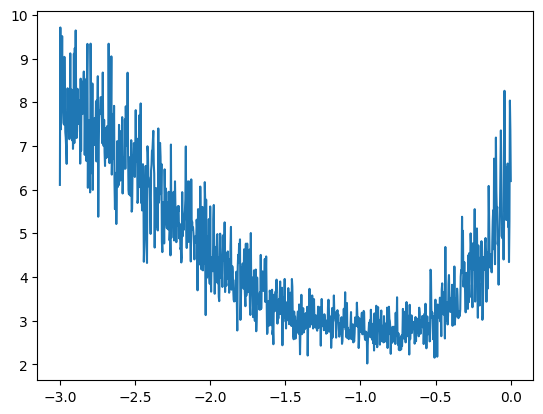

In [127]:
plt.plot(lri, lossi)

In [149]:
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(2.3287, grad_fn=<NllLossBackward0>)

In [ ]:
# BATCHING
# We have 220k examples. 220k forward passes calculated to get loss. Backward pass has to do a lot of gradient accumulation. 
# takes a lot longer to take a step as training set increases in size
# with a minibatch, takes a lot less time to take a step. this comes at the cost of less accuracy in steps, but that often is not that costly. gradient direction is lower quality, but it's still good enough. 
# better to have an approximate gradient and take many steps, as opposed to having an exact gradient and taking few steps. 

In [ ]:
# FINDING LEARNING RATE
# Just try some shit out 
# Find where learning rate goes at a fucking crawl
# Find where it explodes

In [ ]:
# training, dev/validation, test
# training - used to optimize parameters of model
# validation - used for development over hyperparameters (optimize hyperparameters)
# test - used for validation - every time you evaluate on your test loss, and you learn something from it and improve because of it, you are basically starting to train on the test split as well

In [154]:
# CREATE DATASET

def build_dataset(words):
    X_list: List[List[int]] = []; y_list: List[int] = []
    context_length = 3
    for word in words:
        
        window = [0] * context_length
        for char in word + ".":
            _x = window; X_list.append(_x)
            _y = char_to_idx[char]; y_list.append(_y)
            window = window[1:] + [char_to_idx[char]]
            
    X = torch.tensor(X_list); y = torch.tensor(y_list)
    
    return X, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)); n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

X_train.shape[0], X_dev.shape[0], X_test.shape[0]

(182437, 22781, 22928)

In [173]:
# INIT MODEL
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn((300,), generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))

for p in parameters: # store gradient information
    p.requires_grad = True

10281


In [188]:
# TRAINING LOOP
lossi = []
stepi = []
for i in range(30000):
    # MINIBATCH
    idxs = torch.randint(0, len(X_train), (32,)) # size of 32
    
    # FORWARD PASS
    emb = C[X_train[idxs]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idxs])

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # APPLY UPDATES 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad # type: ignore
        
    # tracking
    stepi.append(i)
    lossi.append(loss.item())
        
print(loss.item()) # type: ignore

2.3386178016662598


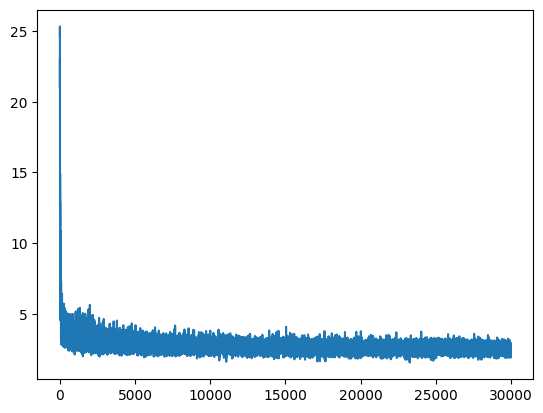

In [175]:
# thickness b.c. mini batches create noise
# if the batch size is too small, the gradient could be innacurate to the point learning slows down. minibatching becomes counterproductive in this case. 
# could also be a matter of bottle-necking. where the 2d vector is too small. increasing layers downstream could very well not help. 
plt.plot(stepi, lossi)

In [189]:
emb = C[X_train]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.2334, grad_fn=<NllLossBackward0>)

In [190]:
emb = C[X_dev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.2622, grad_fn=<NllLossBackward0>)

In [ ]:
# train and val losses are about the same. we have not gotten to the point of overfitting. another possibility is that this model is not complex enough to overfit.
# bottle neck could be the word embeddings. so we'll change that. (I would've never been able to think of this)

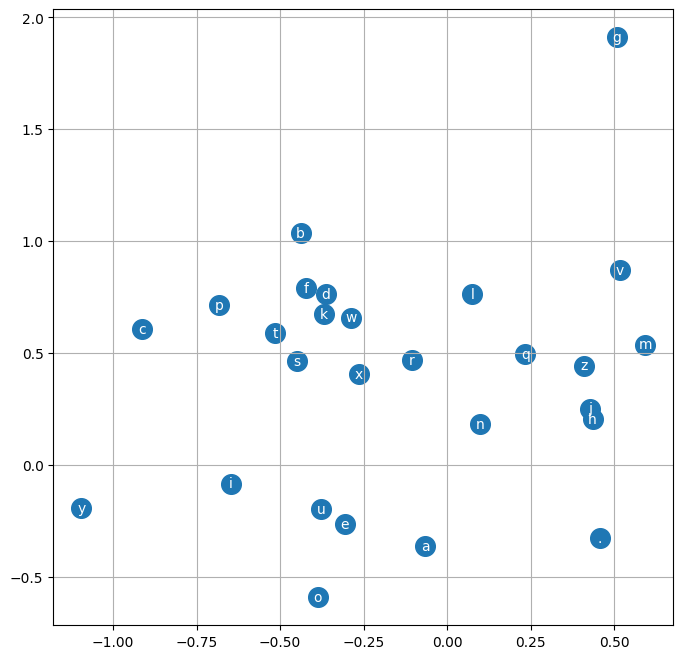

In [191]:
# visualizing embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), idx_to_char[i], ha="center", va="center", color="white")
plt.grid("minor") # type: ignore

## INCREASING EMBEDDING DIMENSIONALITY

In [198]:
# INIT MODEL
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))

for p in parameters: # store gradient information
    p.requires_grad = True

11897


In [199]:
lossi = []
stepi = []

In [209]:
# TRAINING LOOP
for i in range(50000):
    # MINIBATCH
    idxs = torch.randint(0, len(X_train), (32,)) # size of 32
    
    # FORWARD PASS
    emb = C[X_train[idxs]]
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idxs])

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # APPLY UPDATES 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad # type: ignore
        
    # tracking
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item()) # type: ignore

1.9476280212402344


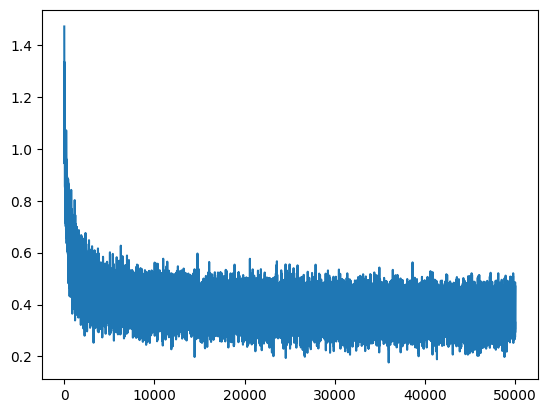

In [201]:
# 50k steps
plt.plot(stepi, lossi)

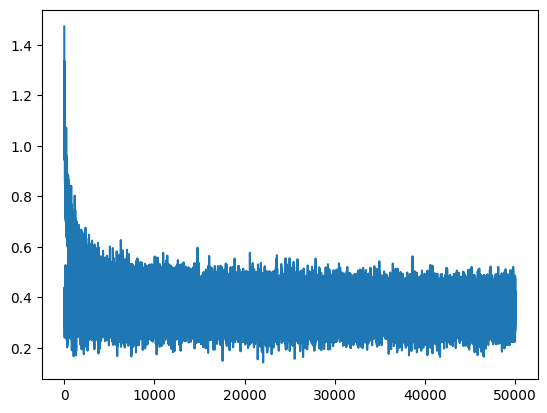

In [206]:
# 100k steps
plt.plot(stepi, lossi)

In [ ]:
# 150k steps
plt.plot(stepi, lossi)

In [210]:
emb = C[X_train]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1675, grad_fn=<NllLossBackward0>)

In [211]:
emb = C[X_dev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.2069, grad_fn=<NllLossBackward0>)

In [ ]:
# Now, the train and validation losses are starting to drift apart. This suggests that the model is starting to overfit. Before there was no departure whatsoever. That implies that the model is not complex enough to overfit. Most likely means that the model is underfitting. Go until you overfit, and that's how you know that you're underfitting. 
# Something to note is that you will rarely touch the test set. Since theoretically, if you see the outputs and make an improvement based upon that, you've fit to it to some extent. As a result, once you're happy with your dev loss, you run it on your test set ONCE (ideally), and report that number in your paper. 

In [216]:
# sampling from this model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        idx = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        
        if idx == 0:
            break
        
    print("".join(idx_to_char[i] for i in out))
        

junide.
jakarie.
presay.
adin.
koim.
laizer.
saree.
kalinaacyanilenias.
dedailewi.
tavsery.
evy.
arterindelmarifortume.
ponne.
walesani.
core.
yar.
octay.
jamir.
edimiil.
wyn.


## Attempting to beat Performance Metrics
- My ideas. 
    - **Increase the amount of characters available as information**
    - Increase batch size. Loss thrashes around a little too much. Having more accurate gradients would likely help. Increase size of hidden layer. 
    - Keep the 10 dimensional embedding. That probably helps quite a bit. 

AIMING TO BEAT 2.17 on validation loss
- Knobs mentioned
    - Increase size of hidden layer -> 300 neurons
    - Increase dimensionality of encodings == same
    - Change # of previous characters used -> 5 characters
    - Adjust learning rate and how it decays -> 0.1 - 0.01 (100k steps)
    - Increase batch size -> 128 batch size

In [243]:
# CREATE DATASET

def build_dataset(words):
    X_list: List[List[int]] = []; y_list: List[int] = []
    context_length = 5
    for word in words:
        
        window = [0] * context_length
        for char in word + ".":
            _x = window; X_list.append(_x)
            _y = char_to_idx[char]; y_list.append(_y)
            window = window[1:] + [char_to_idx[char]]
            
    X = torch.tensor(X_list); y = torch.tensor(y_list)
    
    return X, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)); n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

X_train.shape[0], X_dev.shape[0], X_test.shape[0]

(182512, 22860, 22774)

In [244]:
for i in range(10):
    inp = [idx_to_char[temp.item()] for temp in X_train[i]] # type: ignore
    print(f"{''.join(inp)} ---> {idx_to_char[y_train[i].item()]}") # type: ignore

..... ---> e
....e ---> m
...em ---> e
..eme ---> r
.emer ---> s
emers ---> e
merse ---> n
ersen ---> .
..... ---> m
....m ---> e


In [245]:
# INIT MODEL
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((50, 250), generator=g)
b1 = torch.randn((250,), generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))

for p in parameters: # store gradient information
    p.requires_grad = True

19797


In [246]:
# TRAINING LOOP
for i in range(100000):
    # MINIBATCH
    idxs = torch.randint(0, len(X_train), (128,))
    
    # FORWARD PASS
    emb = C[X_train[idxs]]
    h = torch.tanh(emb.view((-1, 50)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idxs])

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # APPLY UPDATES 
    
    lr = None
    if i < 5000:
        lr = 1
    elif i < 25000: # maybe 20000
        lr = 0.5
    elif i < 40000: 
        lr = 0.1
    elif i < 75000: # maybe 55000 - spend more time with fine adjustments. Some way to automatically try loss (adam) would be most likely helpful. 
        lr = 0.01
    else:
        lr = 0.005
        
    for p in parameters:
        p.data -= lr * p.grad # type: ignore
        
    # tracking
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    if i % 1000 == 0:
        print(f"{i:06}: {loss.item():.4f}")
        
print(loss.item()) # type: ignore

000000: 30.2042
001000: 7.0239
002000: 6.0267
003000: 4.8375
004000: 3.8930
005000: 5.7879
006000: 2.4770
007000: 2.1932
008000: 2.3362
009000: 2.5565
010000: 2.5055
011000: 2.6277
012000: 2.3026
013000: 2.3159
014000: 2.1905
015000: 2.5310
016000: 2.4786
017000: 2.4778
018000: 2.2631
019000: 2.1991
020000: 2.0872
021000: 2.2176
022000: 2.3484
023000: 2.3433
024000: 2.3627
025000: 2.2938
026000: 2.0786
027000: 2.2539
028000: 2.2739
029000: 2.1178
030000: 1.9420
031000: 1.9152
032000: 1.9926
033000: 2.0493
034000: 2.0167
035000: 2.1238
036000: 2.0184
037000: 1.8518
038000: 1.9202
039000: 2.1357
040000: 2.1718
041000: 2.1142
042000: 2.1716
043000: 1.9433
044000: 2.0595
045000: 2.0563
046000: 1.9985
047000: 1.9425
048000: 1.9440
049000: 2.2430
050000: 1.9575
051000: 2.1037
052000: 2.1557
053000: 1.9823
054000: 2.0188
055000: 2.0676
056000: 2.0955
057000: 1.9312
058000: 2.0018
059000: 1.9201
060000: 2.0190
061000: 2.0053
062000: 1.9672
063000: 2.0146
064000: 1.9457
065000: 2.0971
066000: 2

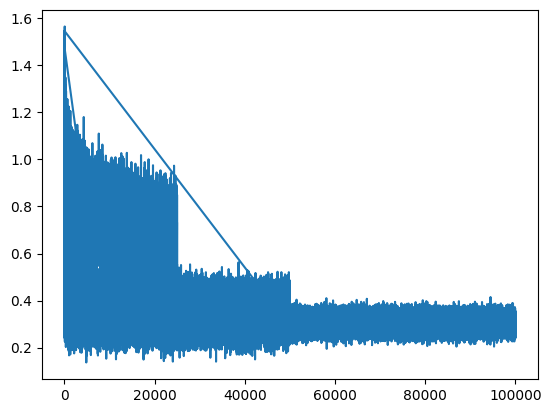

In [247]:
# ???
plt.plot(stepi, lossi)

In [248]:
emb = C[X_train]
h = torch.tanh(emb.view((-1, 50)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(1.9984, grad_fn=<NllLossBackward0>)

In [249]:
emb = C[X_dev]
h = torch.tanh(emb.view((-1, 50)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.1087, grad_fn=<NllLossBackward0>)

In [ ]:
# well, i beat it. 2.1087. Learning Rate was important. There were periods of time where it just kinda thrashed around. No finese to get into the good spots. increasing batch sizes over time could also help. 

In [255]:
# sampling from this model
g = torch.Generator().manual_seed(2147483647 + 16) # 0 10 20

for _ in range(200):
    out = []
    context = [0] * 5
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view((-1, 50)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        idx = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        
        if idx == 0:
            break
        
    print("".join(idx_to_char[i] for i in out))
    
# monaim => moniam
# rowia
# kaison
# manalyna -> manalyn
# leisa
# serraanna -> serana
# julia
# herna -> hernathas
# kasia -> kasiya
# priste
# kehzen -> kezia

rowia.
yem.
jaki.
mil.
amariah.
kovani.
leanor.
luchi.
wedla.
makay.
luzak.
mungella.
jeoni.
aloi.
jalandelah.
rhany.
ilii.
noir.
nya.
edry.
lyorelee.
evrion.
kuelah.
yanex.
zakari.
niiri.
lon.
rodel.
kaison.
khitha.
oynoye.
norie.
moana.
lon.
xinlinn.
aqacham.
zakerest.
novan.
ko.
haddo.
braxtiona.
evyar.
matim.
kion.
jaylin.
doniel.
jonyel.
jucbriann.
caesen.
hani.
jaxier.
aeghonyen.
bavyriy.
braxth.
demet.
tayanah.
bevally.
samaracelidia.
foassa.
jamare.
thlyz.
indva.
caestin.
risha.
omansa.
rae.
yathwan.
fino.
konnen.
padde.
kayah.
nashi.
mavi.
jaylin.
andersone.
mesken.
valie.
cakou.
harmy.
samadah.
amyra.
framil.
braleigh.
karon.
emmera.
rawia.
lasece.
jamia.
berlan.
demmithinkan.
cabeliah.
nora.
leeliciu.
kehzen.
adiel.
kyndite.
daive.
priste.
kasia.
muhranuloun.
bateta.
toube.
jentrea.
japkinnysi.
neymonu.
quon.
dunna.
zalany.
manalyna.
annaler.
dignay.
amond.
madantay.
kamari.
yoni.
kolly.
benix.
lous.
sufer.
trayven.
jlynnn.
ktin.
nestyn.
connyn.
heaghan.
casemy.
leisa.
edin.